**Begin with the necessary imports and constants**

In [67]:
import numpy as np
import itertools as it
import os 
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from scipy.spatial.distance import cosine

**We're going to compare gene sequences as vectors**

**In order to do that, we'll need some way to quantize them. A simple was is with base pair counts**

**That would leave us with vectors of size = 4, one dimension per base pair**

**Alternatively, we could quantize with respect to reads of length > 1. Here's what that might look like**

In [69]:
list(it.product(BASES, repeat = 2))

[('A', 'A'),
 ('A', 'C'),
 ('A', 'T'),
 ('A', 'G'),
 ('C', 'A'),
 ('C', 'C'),
 ('C', 'T'),
 ('C', 'G'),
 ('T', 'A'),
 ('T', 'C'),
 ('T', 'T'),
 ('T', 'G'),
 ('G', 'A'),
 ('G', 'C'),
 ('G', 'T'),
 ('G', 'G')]

**Many sample sequence files are already saved nearby. Here's how we vectorize those**

In [70]:
def genome_vector_mini(file, subsequence_size=2):
    
    full_genome = np.genfromtxt(file, delimiter=',', dtype=np.int8)
    
    # remove the last partial subsequence, if necessary
    if len(full_genome) % subsequence_size != 0:
        full_genome = full_genome[:-(len(full_genome) % subsequence_size)]

    resized = full_genome.reshape((-1,subsequence_size)).astype(np.int64)
    
    shifts = np.arange(subsequence_size)
    shifted = (resized - 1) * (4)**shifts
    
    # encoded reads of length subsequence_size
    bp_subsequences = shifted.sum(axis=1)
    
    # ('actg', 1) -> [1,1,1,1] ------ ('aagg', 2) -> [1,0,0...,1]
    uniques, counts = np.unique(bp_subsequences, return_counts=True)
    
    normalized = np.zeros(4**subsequence_size)
    normalized[uniques] = counts
    normalized /= counts.sum()
    return normalized

**Dimensionality increases by a factor of 4 for each read we track. Sparsity issues ensue**

In [71]:
genome_vector_mini('mini/Armadillo--dasNov3.mini', 5).shape

(1024,)

**A considerable amount of data cleaning is done elsewhere. We'll read that data now**

In [73]:
subsequence_size = 5
filenames = ['mini/'+f for f in os.listdir('mini')]
data = [ genome_vector_mini(f, subsequence_size) for f in filenames ]
species = [ f.split('--')[0].split('/')[1] for f in filenames ]

**Although the vectors are too large to visualize, we can see most of the variance with PCA**

**It's hard to tell whether this vectorization is biologically meaningful as it stands**

explained variance 71.09958964080178%


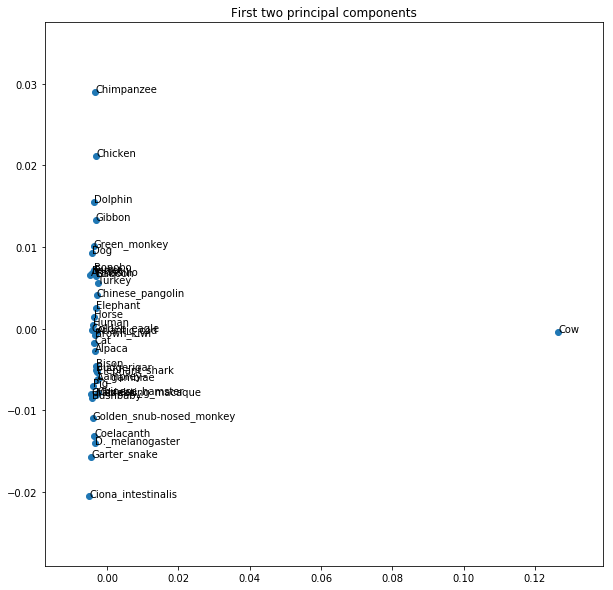

In [76]:
def plotPCA(data, labels=None, colors=None, title=None):
    
    pca = PCA(n_components=2)
    components = pca.fit_transform(data)
    var = pca.explained_variance_ratio_[:2].sum() * 100
    
    x,y = components[:,0], components[:,1]
    num_items = len(labels)
    
    plt.figure(figsize=(10,10))
    
    if title:
        plt.title(title)
    
    if labels:
        if colors:
            for i, label in enumerate(labels):
                plt.scatter(x[i], y[i], color=colors[i], s=100)
        else:
            plt.scatter(x,y)
        for i, label in enumerate(labels):
            plt.annotate(label, (x[i], y[i]))
    else:
        plt.scatter(x, y)
        
    print(f'explained variance {var}%')
plotPCA(data, labels = species, title = 'First two principal components')

**Now we'll cluster these vectorized sequences according to the KMeans algorithm**

**This entails repeatedly calculating centroids and allocating data to corresponding clusters** 

**This repeats until the clusters don't change much**

In [78]:
def KMeans(data, k):
    '''
    returns branching_factor centroids after convergence
    '''
    centroid_idxs = np.random.choice(len(data), size = k, replace=False)
    centroids = np.array([data[idx] for idx in centroid_idxs])
    initial, init_clusters = np.copy(centroids), None
    changed = True
    
    while changed:
        clusters = [ [] for c in centroids ]
        for i in range(len(data)):
            row = data[i]
            argdists = [ (cluster_idx, cosine(c, row)) for (cluster_idx, c) in enumerate(centroids) ]

            # choose the cluster most cosine-similar to this vector
            min_centroid_idx = min(argdists, key = lambda tup: tup[1])[0]
            clusters[min_centroid_idx] += [i]
            
        if init_clusters == None:
            init_clusters = clusters

        new_centroids = [ None for _ in centroids ]
        dist = 0.0
        for i, cluster in enumerate(clusters):
            if len(cluster) == 0:
                return initial, init_clusters
            centroid = np.zeros(data[0].shape)
            for idx in cluster:
                centroid += data[idx]
            centroid = centroid / len(cluster)
            new_centroids[i] = centroid
            dist += ((centroids[i] - centroid)**2).sum()
        
        changed = dist > .00001
        centroids = new_centroids
    
    return centroids, clusters

**Here's an example with 4 clusters. To illustrate the clusters, we can plot them on our 2-axis PCA projection**

explained variance 80.51517846190059%


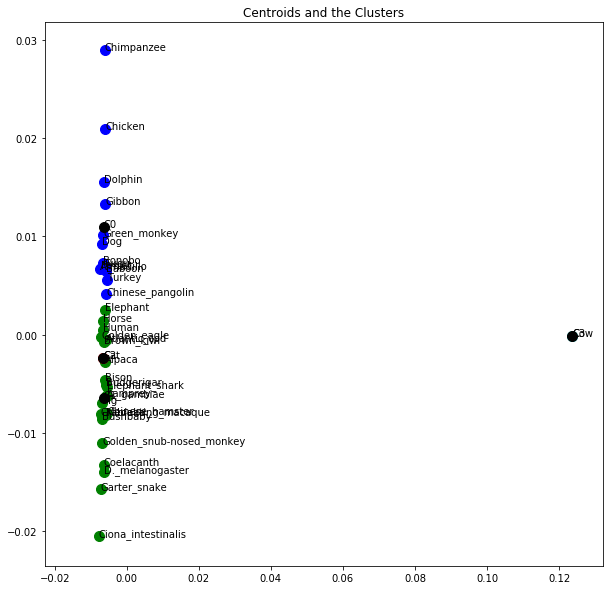

In [81]:
k = 4
centroids, clusters = KMeans(data, k)
# print(centroids)
pltdata = np.concatenate((data, centroids))
pltlabels = species + [f'C{n}' for n in range(k)]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'w'][:k]

pltcolors = [None for _ in range(len(pltdata))]
for i, cluster in enumerate(clusters):
    for idx in cluster:
        pltcolors[idx] = colors[i]
        
for i in range(k):
    pltcolors[-i-1] = 'black'
    
plotPCA(pltdata, labels = pltlabels, colors = pltcolors, title = 'Centroids and the Clusters')

**In order to generate a phylogenetic tree, however, we'll have to examine the centroids and cluster them**

**We repeat until everything is under one root cluster**

In [83]:
def hierarchicalKMeans(data, labels, branching_factor=3):
    
    def recursiveKMeans(data, labels, tree):
        k = len(data) // branching_factor
        if len(data) > branching_factor:
            centroids, clusters = KMeans(data, k)
            cluster_labels = ['c'+str(i+len(tree)) for i in range(len(clusters))]
            for i, cluster in enumerate(clusters):
                for item in cluster:
                    tree[labels[item]] = {'cluster': cluster_labels[i]}
            return recursiveKMeans(centroids, cluster_labels, tree)
        else:
            for i, row in enumerate(data):
                tree[labels[i]] = {'cluster': 'root'}
            return tree
    
    return recursiveKMeans(data, labels, {})

**Here's something that somewhat resembles a phylogenetic tree, at least in structure**

In [84]:
hierarchicalKMeans(data, species, branching_factor=2)

{'A._gambiae': {'cluster': 'c0'},
 'Turkey': {'cluster': 'c1'},
 'Fugu': {'cluster': 'c1'},
 'Dog': {'cluster': 'c2'},
 'Elephant_shark': {'cluster': 'c3'},
 'Pig': {'cluster': 'c3'},
 'Bushbaby': {'cluster': 'c3'},
 'Medaka': {'cluster': 'c3'},
 'Coelacanth': {'cluster': 'c4'},
 'D._melanogaster': {'cluster': 'c4'},
 'Ciona_intestinalis': {'cluster': 'c4'},
 'Garter_snake': {'cluster': 'c4'},
 'Ferret': {'cluster': 'c5'},
 'Cow': {'cluster': 'c6'},
 'Golden_snub-nosed_monkey': {'cluster': 'c7'},
 'Lamprey': {'cluster': 'c7'},
 'Chinese_hamster': {'cluster': 'c7'},
 'Crab-eating_macaque': {'cluster': 'c8'},
 'Cat': {'cluster': 'c8'},
 'Green_monkey': {'cluster': 'c9'},
 'Gibbon': {'cluster': 'c10'},
 'Golden_eagle': {'cluster': 'c11'},
 'Alpaca': {'cluster': 'c12'},
 'Bison': {'cluster': 'c13'},
 'Brown_kiwi': {'cluster': 'c14'},
 'Budgerigar': {'cluster': 'c14'},
 'Armadillo': {'cluster': 'c15'},
 'Baboon': {'cluster': 'c15'},
 'Bonobo': {'cluster': 'c15'},
 'Chinese_pangolin': {'clus

**So, why do 